In [1]:
using Pkg 
Pkg.activate("..");
Pkg.instantiate();

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings  
using Zygote, Optim, ForwardDiff, Flux
using StatsFuns
using MultivariateStats
using KernelFunctions, MAT, LoopVectorization

In [3]:
include("../GPnode/MultiSGPnode.jl")
include("../helper_functions/derivative_helper.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

## Load data

In [4]:
my_file_data = open("../3PhData/DataTrn.txt");
data = read(my_file_data,String);
data = parse.(Float64, split(chop(data; head=1, tail=1)));
data = [data[i:i+11] for i=1:12:length(data)];
;

In [5]:
# N = length(data)
N = 200
data = data[1:N];

In [6]:
my_file_label = open("../3PhData/DataTrnLbls.txt");
label_data = read(my_file_label,String)
label_data = parse.(Float64, split(chop(label_data; head=1, tail=1)));
label_data = [label_data[i:i+2] for i=1:3:length(label_data)];

label_data = label_data[1:N];
;

In [7]:
label_text = Vector{Any}(undef,length(label_data))
for i=1:length(label_data)
    if label_data[i] == [1.0, 0.0, 0.0]
        label_text[i] = "Homogeneous"
    elseif label_data[i] == [0.0, 1.0, 0.0]
        label_text[i] = "Annular"
    else label_text[i] = "Stratified"
    end
end

pos_lb_homogeneous = findall((x) -> x=="Homogeneous",label_text)
pos_lb_annular = findall((x) -> x=="Annular",label_text)
pos_lb_stratified = findall((x) -> x=="Stratified",label_text)
;

In [8]:
D_out = length(data[1])
D_in = 2
;

In [9]:
# perform PCA
matrix_data = hcat(data...) ;
M = fit(PCA, matrix_data; maxoutdim=2)
mX = predict(M, matrix_data)
;

In [10]:
mean_X = [mX[:,i] for i=1:N];

## GPLVM model

In [11]:
@model function GPLVM(y,Xm, d_in, d_out, Kuu_big,θ)
    v ~ MvNormalWeightedMeanPrecision(zeros(size(Kuu_big,1)), Kuu_big)
    
    for i=1:length(y)
        x[i] ~ MvNormalMeanCovariance(Xm[i], 100diageye(d_in))
        y[i] ~ MultiSGP(x[i],v,1e2diageye(d_out),θ) where { dependencies = RequireMarginalFunctionalDependencies(in = MvNormalMeanCovariance(mean_X[i], diageye(d_in)),)}
    end
end
;

## Configure GP

In [12]:
Random.seed!(86)
M = 30
pos_Xu = randperm(N)[1:M]
Xu = mean_X[pos_Xu]

kernel_gp(θ) = StatsFuns.softplus(θ[1]) * with_lengthscale(SEKernel(),StatsFuns.softplus.([θ[2],θ[3]])) 
W = 1e2diageye(D_out)
tr_W = tr(W)
gp_method = srcubature()
gp_cache = GPCache()
dim_v = D_out * length(Xu)
C = diageye(D_out)
M = length(Xu)
Ψ0 = [1.0;;]
Ψ1_trans = kernelmatrix(kernel_gp([1.,1.,1.]),Xu,[ones(D_in)])
Ψ2 = kernelmatrix(kernel_gp([1.,1.,1.]),Xu,[ones(D_in)]) * kernelmatrix(kernel_gp([1.,1.,1.]),[ones(D_in)],Xu)
;

In [13]:
@meta function gpssm_meta(method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel,cache)
    MultiSGP() -> MultiSGPMeta(method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel,cache)
end

gp_constraint = @constraints begin
    q(x,v) = q(x)q(v)
end
;

In [14]:
function my_free_energy(θ)
    Kuu = kernelmatrix(kernel_gp(θ),Xu) + 1e-12*I
    Kuu_inverse = inv(Kuu)
    Kuu_big = kron(C,Kuu)
    init = @initialization begin
        q(v) = MvNormalWeightedMeanPrecision(zeros(dim_v), Kuu_big)
    end
    
    infer_result_gp = infer(
        model = GPLVM(d_in = D_in, d_out = D_out, Kuu_big = Kuu_big,θ = θ),
        iterations = 6,
        data = (y = data, Xm = mean_X,),
        initialization = init,
        constraints = gp_constraint,
        meta = gpssm_meta(gp_method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel_gp,gp_cache),
        free_energy = true,
    ) 
    return infer_result_gp.free_energy[end]
end

function learn_params(θ)
    res = optimize((x) -> my_free_energy(x),θ,NelderMead(),Optim.Options(store_trace=true,iterations=25))
    return res
end

learn_params (generic function with 1 method)

In [15]:
θ_init = [1, 0.6,0.5]
optimal_result = learn_params(θ_init) #approx 15 min
; 

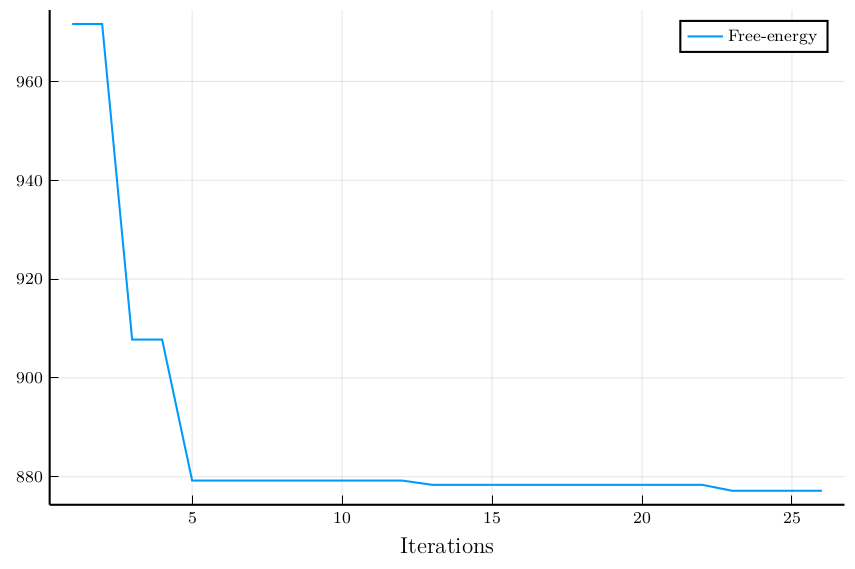

In [16]:
FE = []
for i=1:length(optimal_result.trace)
    append!(FE,optimal_result.trace[i].value)
end
plot(FE, label = "Free-energy", xlabel = "Iterations",legend=:topright)

In [47]:
savefig("../texfiles/GPLVM_FE.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/GPLVM_FE.svg"

In [18]:
println("Optimal hyperparameters: ", StatsFuns.softplus.(θ_optimal))

Optimal hyperparameters: [1.4135870862973339, 0.7674621938778089, 1.0214698674104508]


## Infer q(x)

In [19]:
 Kuu = kernelmatrix(kernel_gp(θ_optimal),Xu) + 1e-12*I
Kuu_inverse = inv(Kuu)
Kuu_big = kron(C,Kuu)
gp_initialization = @initialization begin
    q(v) = MvNormalWeightedMeanPrecision(zeros(dim_v), Kuu_big)
end
infer_result_gp = infer(
    model = GPLVM(d_in = D_in, d_out = D_out, Kuu_big=Kuu_big,θ = θ_optimal),
    iterations = 30,
    data = (y = data, Xm = mean_X,),
    initialization = gp_initialization,
    constraints = gp_constraint,
    meta = gpssm_meta(gp_method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel_gp,gp_cache),
    options = (limit_stack_depth = 400, ), 
    returnvars = ( x = KeepLast(),),
    free_energy = true,
) 

Inference results:
  Posteriors       | available for (x)
  Free Energy:     | Real[1.56281e5, 1926.28, 1217.82, 1024.26, 933.157, 877.162, 836.848, 799.746, 774.151, 754.544  …  684.759, 667.796, 665.506, 663.521, 661.741, 660.163, 658.683, 657.232, 655.813, 654.362]


In [21]:
qx = infer_result_gp.posteriors[:x];
;

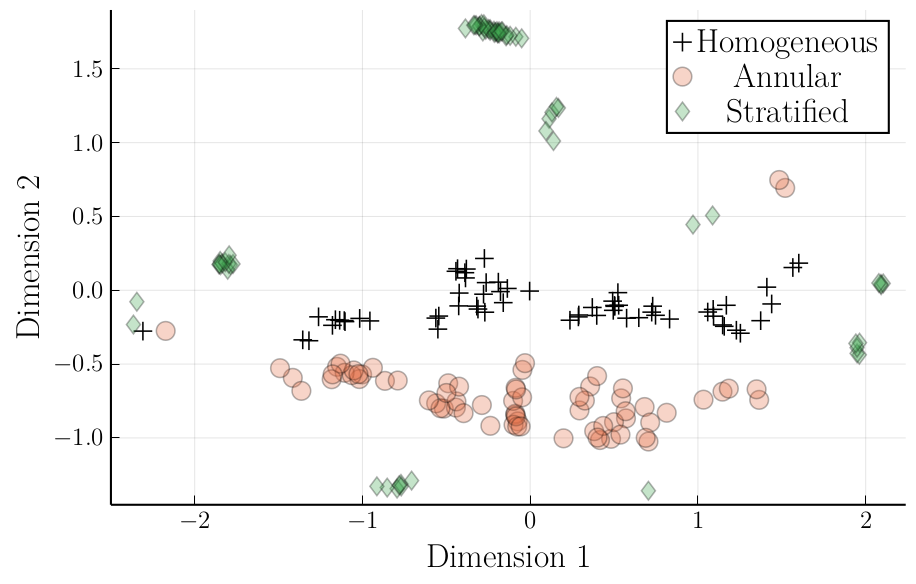

In [39]:
# contourf(x, y, p,fill=true, levels=20, color=:pigeon)
scatter(getindex.(mean.(qx),1)[pos_lb_homogeneous],getindex.(mean.(qx),2)[pos_lb_homogeneous],
        label = "Homogeneous",
        markersize=6.,
        legend=:topright,
        marker = :cross,
        fontfamily="monospace",legendfontsize=16,
        tickfontsize=12,guidefontsize=16)

scatter!(getindex.(mean.(qx),1)[pos_lb_annular],getindex.(mean.(qx),2)[pos_lb_annular],
        label = "Annular",
        markersize=6.,
        alpha=0.3)

scatter!(getindex.(mean.(qx),1)[pos_lb_stratified],getindex.(mean.(qx),2)[pos_lb_stratified],
        label = "Stratified",
        markersize=6.,
        marker = :diamond,
        alpha=0.3)
# scatter!(getindex.(Xu,1),getindex.(Xu,2),legend=false)
xlabel!("Dimension 1")
ylabel!("Dimension 2")

In [40]:
savefig("../texfiles/GPLVM_SGPresult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/GPLVM_SGPresult.svg"

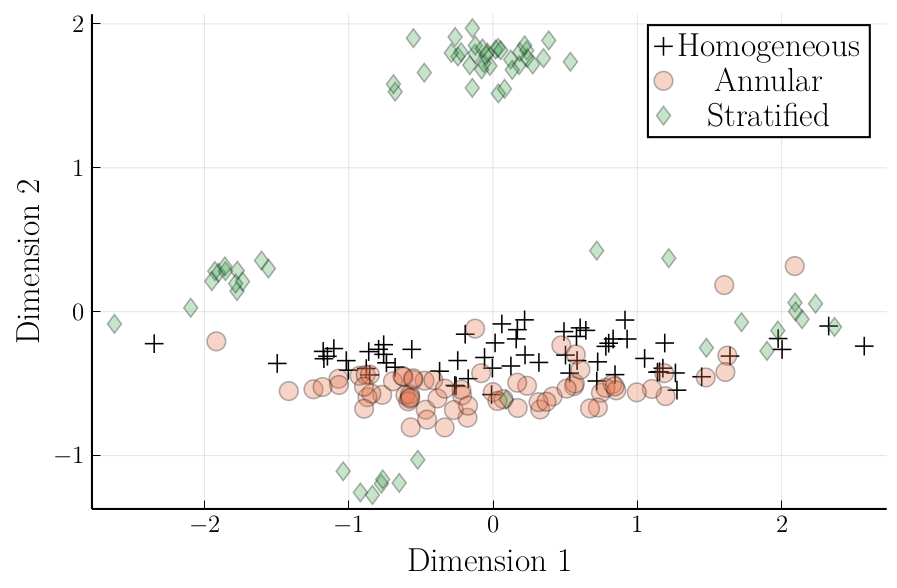

In [37]:
scatter(mX[1,pos_lb_homogeneous],mX[2,pos_lb_homogeneous],label = "Homogeneous",
         markersize=6,
         legend=:topright,
         marker = :cross,
         fontfamily="monospace",legendfontsize=16,
         tickfontsize=12,guidefontsize=16)

scatter!(mX[1,pos_lb_annular],mX[2,pos_lb_annular],label = "Annular",
        markersize=6,
        alpha=0.3)
scatter!(mX[1,pos_lb_stratified],mX[2,pos_lb_stratified],label = "Stratified",
        markersize=6,
        marker=:diamond,
        alpha=0.3)

xlabel!("Dimension 1")
ylabel!("Dimension 2")

In [38]:
savefig("../texfiles/GPLVM_PCAresult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/GPLVM_PCAresult.svg"

In [ ]:
# plot(infer_result_gp.free_energy, label="free energy", legend=:topright)
# xlabel!("iterations")

In [56]:
# savefig("texfiles/GPLVM_FE.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/GPLVM_FE.svg"

In [ ]:
# x = -2.5:0.02:2.5
# y = -2.5:0.02:2.5
# X = repeat(reshape(x, 1, :), length(y), 1)
# Y = repeat(y, 1, length(x))

# function myfunc(d, X, Y)
#     Z = map((x,y) -> pdf(d,[x,y]), X, Y)
#     replace!(x -> x < 1e-6 ? 0. : x, Z)
#     return Z
# end

# p = zeros(length(x),length(x))
# for i=1:length(qx) 
#     p += myfunc(qx[i],X,Y)
# end
# contourf(x, y, p,fill=true, levels=20, color=:pigeon)

In [ ]:
# function my_free_energy(θ)
    #     Kuu = kernelmatrix(kernel_gp(θ),Xu) + 1e-12*I
    #     Kuu_inverse = cholinv(Kuu)
    #     Kuu_big = kron(C,Kuu)
    #     gp_initialization = @initialization begin
    #         q(v) = MvNormalWeightedMeanPrecision(zeros(dim_v), Kuu_big)
    #     end
    #     infer_result_gp = infer(
    #         model = GPLVM(d_in = D_in, d_out = D_out,Kuu_big=Kuu_big,θ = θ),
    #         iterations = 6,
    #         data = (y = data, Xm = mean_X,),
    #         initialization = gp_initialization,
    #         constraints = gp_constraint,
    #         meta = gpssm_meta(gp_method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel_gp,gp_cache),
    #         returnvars = (v = KeepLast(), x = KeepLast(),),
    #         free_energy = true,
    #     ) 
        
    #     return infer_result_gp.free_energy[end], infer_result_gp.posteriors[:x], infer_result_gp.posteriors[:v]
    # end
    
    # # function my_free_energy(θ;mx, Σx, mv, Σv)
    # #         Kuu = kernelmatrix(kernel_gp(θ),Xu) + 1e-12*I
    # #         Kuu_inverse = cholinv(Kuu)
    # #         gp_initialization = @initialization begin
    # #             q(v) = MvNormalWeightedMeanPrecision(mv, Σv)
    # #         end
    # #         infer_result_gp = infer(
    # #             model = GPLVM(mx = mx, Σx = Σx, mv=mv,Σv = Σv,θ = θ),
    # #             iterations = 10,
    # #             data = (y = data,),
    # #             initialization = gp_initialization,
    # #             constraints = gp_constraint,
    # #             meta = gpssm_meta(gp_method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel_gp,gp_cache),
    # #             returnvars = (v = KeepLast(), x = KeepLast(),),
    # #             free_energy = true,
    # #         ) 
            
    # #         return infer_result_gp.free_energy[end], infer_result_gp.posteriors[:x], infer_result_gp.posteriors[:v]
    # #     end
    
    # function PerformInference(θ; epochs)
    #     FE_value = []
    #     θ_optimal = θ
    #     grad = similar(θ)
    #     optimizer = Flux.AdaMax()
    #     # Kuu = kernelmatrix(kernel_gp(θ),Xu) + 1e-12*I
    #     # Kuu_big = kron(C,Kuu)
    #     # mx = mean_X
    #     # Σx = [100diageye(D_in) for i=1:N]
    #     # mv = zeros(dim_v)
    #     # Σv = Kuu_big
    #     @inbounds for epoch=1:epochs
    #             #step 1: Perform inference for v, w 
    #             fe, qx, qv = my_free_energy(θ_optimal)
    #             # fe, qx, qv = my_free_energy(θ_optimal;mx=mx,Σx=Σx,mv=mv,Σv=Σv)
    #             #step 2: optimize the hyperparameters 
    #             μ_v, Σ_v = mean_cov(qv)
    #             Rv = Σ_v + μ_v * μ_v' 
    #             sumRv_Wbar = sum(create_blockmatrix(Rv,D_out,M) .* W);
    #             # @inbounds for k=1:50
    #             #     grad_llh_multi!(grad,θ_optimal; y_data=data,
    #             #                                     qx = qx,
    #             #                                     sumRv_Wbar = sumRv_Wbar,
    #             #                                     v = μ_v,
    #             #                                     W = W,
    #             #                                     tr_W = tr_W,
    #             #                                     kernel=kernel_gp,
    #             #                                     Xu=Xu,
    #             #                                     method=gp_method)
    #             #     Flux.Optimise.update!(optimizer,θ_optimal,grad)
    #             # end
    #             neg_llh = (θ) -> neg_log_backwardmess_multi(θ; y_data=data,
    #                                                 qx = qx,
    #                                                 sumRv_Wbar = sumRv_Wbar,
    #                                                 v = μ_v,
    #                                                 W = W,
    #                                                 tr_W = tr_W,
    #                                                 kernel=kernel_gp,
    #                                                 Xu=Xu,
    #                                                 method=gp_method)
    #             grad! = (G,θ) -> grad_llh_multi!(G,θ;y_data=data,
    #                                                     qx = qx,
    #                                                     sumRv_Wbar = sumRv_Wbar,
    #                                                     v = μ_v,
    #                                                     W = W,
    #                                                     tr_W = tr_W,
    #                                                     kernel=kernel_gp,
    #                                                     Xu=Xu,
    #                                                     method=gp_method)
    #             res = optimize(neg_llh, grad!, θ_optimal, LBFGS(), Optim.Options(show_trace=true,time_limit=1))
    #             θ_optimal = res.minimizer
    #             # mx= mean.(qx)
    #             # Σx = cov.(qx)
    #             # mv, Σv = mean_cov(qv)
    #             append!(FE_value,fe)
    #     end
    #     return FE_value, θ_optimal
    # end
    # # θ_init = [0.5, -1.,-0.4]
    # θ_init = [1, 0.3, 0.5]
    # @time fe,θ_optimal= PerformInference(θ_init;epochs=1);

    # @model function GPLVM(y,Xm, d_in, d_out,dim_v,Kuu_big, θ)
    
#     v ~ MvNormalWeightedMeanPrecision(zeros(dim_v),Kuu_big)
#     W ~ Wishart(1e4,diageye(d_out))
#     for i=1:length(y)
#         x[i] ~ MvNormalMeanCovariance(Xm[i], 100diageye(d_in))
#         y[i] ~ MultiSGP(x[i],v,W,θ) where { dependencies = RequireMarginalFunctionalDependencies(in = MvNormalMeanCovariance(mean_X[i], diageye(d_in)),)}
#     end
# end
# @model function GPLVM(y,mx,Σx, mv, Σv, θ)
    
#     v ~ MvNormalWeightedMeanPrecision(mv, Σv)
    
#     for i=1:length(y)
#         x[i] ~ MvNormalMeanCovariance(mx[i], Σx[i])
#         y[i] ~ MultiSGP(x[i],v,1e2diageye(D_out),θ) where { dependencies = RequireMarginalFunctionalDependencies(in = MvNormalMeanCovariance(mx[i], Σx[i]),)}
#     end
# end